# Slides for week 1 of PREM 4 DERG

This is a set of slides and code for week 1 of the PREM for DERG sessions.
It is a slide show to introduce PREM, to get people thinking, and to have some
code to play with.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

# have you cited PREM?

# What is PREM

In [2]:
# Show PREM plots

In [3]:
class PeicewisePolynomial(object):
    """
    Peicewise Polynomials a different way
    
    The SciPy PPoly class defines a function from
    polynomials with coefficents c and breakpoints x
    evaluated at a point xp thus:
    
       S = sum(c[m, i] * (xp - x[i])**(k-m) for m in range(k+1))
    
    This is not helpful for PREM, so we wrap PPoly and make a 
    new class defining the function:
    
       S = sum(c[m, i] * (xp - x[i])**(k-m) for m in range(k+1))
       
    """
    
    def __init__(self, c, x):
        self.breakpoints = x 
        self.coeffs = c
        
        
    def __call__(self, xp):
        if np.ndim(xp) == 0:
            value = self._evaluate_at_point(xp)
        else:
            value = np.zeros_like(xp)
            for i in range(xp.size):
                value[i] = self._evaluate_at_point(xp[i])
        return value        
        
        
    def _evaluate_at_point(self, x):
        """
        Evaluate peicewise polynomal at point x
        """
        coef = self._get_coefs(x)
        value = self._evaluate_polynomial(x, coef)
        return value
        
        
    def _evaluate_polynomial(self, x, coef):
        value = 0
        for i, c in enumerate(coef):
            value = value + c * x**i
        return value
        
        
    def _get_coefs(self, x):
        """
        Return coefs at x
        """
        for i in range(self.breakpoints.size):
            if (x >= self.breakpoints[i]) and (x < self.breakpoints[i+1]):
                return self.coeffs[i,:]
        
        return None
    
    
    def derivative(self):
    
        deriv_breakpoints = self.breakpoints
        deriv_coeffs = np.zeros((self.coeffs.shape[0], self.coeffs.shape[1]-1))
        for seg in range(self.coeffs.shape[0]):
            for i in range(self.coeffs.shape[1]):
                if i == 0:
                    continue # Throw away term for x**0
                deriv_coeffs[seg,i-1] = self.coeffs[seg,i]*i
                
        deriv = PeicewisePolynomial(deriv_coeffs, deriv_breakpoints)
        return deriv
    
    def antiderivative(self):
        
        antideriv_breakpoints = self.breakpoints
        antideriv_coeffs = np.zeros((self.coeffs.shape[0], self.coeffs.shape[1]+1))
        for seg in range(self.coeffs.shape[0]):
            for i in range(self.coeffs.shape[1]):
                antideriv_coeffs[seg,i+1] = self.coeffs[seg,i]/(i+1)
                
        antideriv = PeicewisePolynomial(antideriv_coeffs, antideriv_breakpoints)
        return antideriv
    
    
    def integrate(self, a, b):
        
        antiderivative = self.antiderivative()
        integral = 0
        lower_bound = a
        for bpi, bp in enumerate(self.breakpoints[:-2]):
            if bp > lower_bound:
                if self.breakpoints[bpi+1] >= b:
                    # Just the one segment left - add it and end
                    integral = integral + (antiderivative(b) - antiderivative(lower_bound))
                    break
                else:
                    # segment from lower bound to bp
                    # add it, increment lower_bound and contiue
                    integral = integral + (antiderivative(bp) - antiderivative(lower_bound))
                    lower_bound = bp

        return integral

In [4]:
class Prem(object):
    
    def __init__(self, breakpoints, density_params, r_earth=6371):
        
        self.r_earth = r_earth
        
        self.density_poly = PeicewisePolynomial(density_params, 
                                           breakpoints/self.r_earth)
        
    def density(self, r):
        """
        Evaluate density in kg/m**3 at radii r (in km)
        """
        # Note unit conversion
        return self.density_poly(r/self.r_earth) * 1000.0
        

In [5]:
# This implements the PREM density model using 



# Polynomial coefficents for PREM density. 
# Note that the array is transposed to match 
# what Scipy's PPoly needs.
density_params = np.array([[13.0885,  0.0000, -8.8381,  0.0000],
                           [12.5815, -1.2638, -3.6426, -5.5281],
                           [7.9565, -6.4761,  5.5283, -3.0807],
                           [7.9565, -6.4761,  5.5283, -3.0807],
                           [7.9565, -6.4761,  5.5283, -3.0807],
                           [5.3197, -1.4836,  0.0000,  0.0000],
                           [11.2494, -8.0298,  0.0000,  0.0000],
                           [7.1089, -3.8045,  0.0000,  0.0000],
                           [2.6910,  0.6924,  0.0000,  0.0000],
                           [2.6910,  0.6924,  0.0000,  0.0000],
                           [2.9000,  0.0000,  0.0000,  0.0000],
                           [2.6000,  0.0000,  0.0000,  0.0000],
                           [1.0200,  0.0000,  0.0000,  0.0000]])

# All 14 discontiuities in PREM in km.
breakpoints = np.array([0.0, 1221.5, 3480.0, 3630.0, 5600.0, 5701.0, 5771.0,
                        5971.0, 6151.0, 6291.0, 6346.6, 6356.0, 6368.0, 6371.0])

r_earth = 6371

prem = Prem(breakpoints, density_params, r_earth=r_earth)

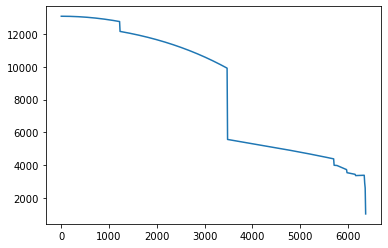

In [6]:

fig, ax = plt.subplots()

rs = np.arange(0, 6371, 10)
ax.plot(rs, prem.density(rs))

plt.show()

In [7]:
prem_density_antideriv = prem.density_poly.antiderivative()


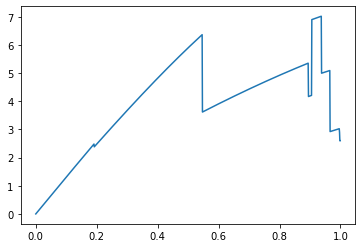

In [8]:
fig, ax = plt.subplots()

rs = np.arange(0, 1, 0.001)
ax.plot(rs, prem_density_antideriv(rs))

plt.show()



In [9]:
prem_density_deriv = prem.density_poly.derivative()


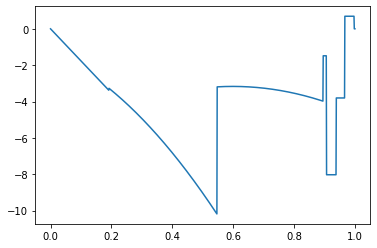

In [10]:
fig, ax = plt.subplots()

rs = np.arange(0, 1, 0.001)
ax.plot(rs, prem_density_deriv(rs))

plt.show()